## Importing Libraries

In [ ]:
# <==== Importing Neccesary libraries ===>
import os
import numpy as np
from numpy import loadtxt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from PIL import Image
import random
from random import shuffle
import cv2
from tqdm import tqdm
from PIL import Image
from random import shuffle
from scipy import interp
from itertools import cycle

# <==== Tensorflow & Machine Learning lib ===>
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# <==== Performance Metrics ===>
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

## Data Loading & Preprocessing

In [ ]:
# <==== Setting path of directory ===>
BASE_DIR = "ISIC_2019_ML"
BCC_DIR = os.path.join(BASE_DIR, "Bcc")
MELANOMA_DIR = os.path.join(BASE_DIR, "Melanoma")
NAVUS_DIR = os.path.join(BASE_DIR, "Navus")
I_VARIABLES_DIR = os.path.join(BASE_DIR, "isic_vars")

In [ ]:
# Load saved variables and files

loaded_len_data = np.load(I_VARIABLES_DIR + "/len_data.npy")
loaded_test_len = np.load(I_VARIABLES_DIR + "/test_len.npy")
loaded_x_test = np.load(I_VARIABLES_DIR + "/x_test.npy")
loaded_y_test = np.load(I_VARIABLES_DIR + "/y_test.npy")
loaded_num_classes = np.load(I_VARIABLES_DIR + "/num_classes.npy")
loaded_train_len = np.load(I_VARIABLES_DIR + "/train_len.npy")
loaded_x_train = np.load(I_VARIABLES_DIR + "/x_train.npy")
loaded_y_train = np.load(I_VARIABLES_DIR + "/y_train.npy")


In [ ]:
# Image augmentation: used here to increase the diversity of the training dataset

image_data_generator = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)


reference: https://keras.io/api/applications/mobilenet/

reference: https://github.com/EhabR98/Transfer-Learning-with-MobileNetV2

reference: https://tahera-firdose.medium.com/transfer-learning-with-mobilenet-cdafe54b5c42

## Model Building

In [ ]:
# Loading the MobileNetV2 convolutional base with pre-trained weights

mobile_net_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

# Setting all layers in the convolutional base to be trainable
for mobile_net_layer in mobile_net_base.layers:
    mobile_net_layer.trainable = True


9420800/9406464 [==============================] - 1s 0us/step


reference: https://blog.roboflow.com/how-to-train-mobilenetv2-on-a-custom-dataset/

reference: https://github.com/berkayalan/neural-networks-and-deep-learning/blob/master/Transfer_learning_with_MobileNet_v1.ipynb

reference: https://www.section.io/engineering-education/building-a-multiclass-image-classifier-using-mobilenet-v2-and-tensorflow/#compiling-the-deep-neural-network

reference: https://stackoverflow.com/questions/73764399/adding-layers-to-cnn-model-mobilenetv2

reference: https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2

In [ ]:
# Adding a custom model on top of the MobileNetV2 convolutional base

# Obtain the output tensor of the convolutional base
custom_model_output = mobile_net_base.output
# Apply Global Average Pooling 2D to reduce spatial dimensions
custom_model_output = layers.GlobalAveragePooling2D()(custom_model_output)
# Add a dense layer with 256 units and ReLU activation
custom_model_output = layers.Dense(256, activation='relu')(custom_model_output)
# Apply dropout for regularization
custom_model_output = layers.Dropout(0.2)(custom_model_output)
# Add another dense layer with 64 units and ReLU activation
custom_model_output = layers.Dense(64, activation='relu')(custom_model_output)
# Apply dropout for regularization
custom_model_output = layers.Dropout(0.1)(custom_model_output)
# Output layer with 3 units (for classification) and softmax activation
final_predictions = layers.Dense(3, activation='softmax')(custom_model_output)
# Create the final model by specifying input and output
custom_model = Model(mobile_net_base.input, final_predictions)


In [ ]:
# Define a list of callbacks for the model training process
model_callbacks = [
    ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    # ModelCheckpoint: Save the model after every epoch if the val_loss has improved.
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.0000000000)
]


In [ ]:
# this model took almost 9 hrs to train

# Compile the model
custom_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set batch size
BS = 64

# Print information about training
print("[INFO] training head...")

# Train the model
H = custom_model.fit(
    image_data_generator.flow(x_train, y_train, batch_size=BS),
    steps_per_epoch=train_len // BS,
    validation_data=(x_test, y_test),
    validation_steps=test_len // BS,
    epochs=30,
    callbacks=model_callbacks
)


[INFO] training head...
Epoch 1/30
151/151 [==============================] - 1294s 8s/step - loss: 0.6541 - accuracy: 0.7240 - val_loss: 13.4300 - val_accuracy: 0.3688

Epoch 00001: val_loss improved from inf to 13.42996, saving model to .mdl_wts.hdf5


C:\Users\divya\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
151/151 [==============================] - 1200s 8s/step - loss: 0.5288 - accuracy: 0.7734 - val_loss: 10.7437 - val_accuracy: 0.3688

Epoch 00002: val_loss improved from 13.42996 to 10.74370, saving model to .mdl_wts.hdf5
Epoch 3/30
151/151 [==============================] - 1182s 8s/step - loss: 0.4752 - accuracy: 0.8000 - val_loss: 12.8592 - val_accuracy: 0.3688

Epoch 00003: val_loss did not improve from 10.74370
Epoch 4/30
151/151 [==============================] - 1201s 8s/step - loss: 0.4509 - accuracy: 0.8176 - val_loss: 6.0576 - val_accuracy: 0.3997

Epoch 00004: val_loss improved from 10.74370 to 6.05762, saving model to .mdl_wts.hdf5
Epoch 5/30
151/151 [==============================] - 1182s 8s/step - loss: 0.4061 - accuracy: 0.8307 - val_loss: 9.0906 - val_accuracy: 0.3745

Epoch 00005: val_loss did not improve from 6.05762
Epoch 6/30
151/151 [==============================] - 1174s 8s/step - loss: 0.3848 - accuracy: 0.8427 - val_loss: 9.4362 - val_accuracy: 0.3

In [ ]:
# Load the best saved model weights
loaded_model = load_model('.mdl_wts.hdf5')


In [ ]:
# Save the model with a new version name
loaded_model.save(I_VARIABLES_DIR + '/model_v1.h5')


C:\Users\divya\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Load the saved model with the new version name
loaded_model = load_model(I_VARIABLES_DIR + '/model_v1.h5')


## Model Evaluation

In [ ]:
# Evaluate the model's accuracy on the test set
loaded_model = load_model(I_VARIABLES_DIR + '/model_v1.h5')

# Checking the accuracy
accuracy = loaded_model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test Accuracy: ', accuracy[1])


76/76 [==============================] - 54s 703ms/step - loss: 0.8772 - accuracy: 0.8546

 Test_Accuracy:- 0.8545529246330261


In [ ]:
# Predictions on the test set using the loaded model
rounded_predictions = loaded_model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions[1]  # Print an example prediction (adjust index as needed)


array([1.1331421e-11, 1.0000000e+00, 6.4998287e-09], dtype=float32)

152/152 [==============================] - 51s 336ms/step


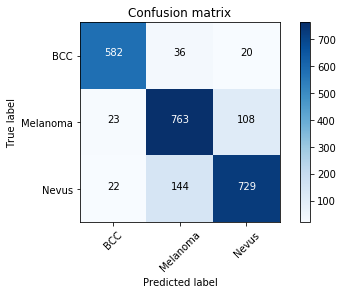

In [ ]:
pred_Y = loaded_model.predict(x_test, batch_size=16, verbose=True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names = ['BCC', 'Melanoma', 'Nevus']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(pred_Y, axis=1)
# Convert validation observations to one hot vectors
rounded_labels = np.argmax(y_test, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(3))


In [ ]:
# Predictions on the test set
predIdxs = loaded_model.predict(x_test, batch_size=BS)

# Find the index of the label with the largest predicted probability for each image
predIdxs = np.argmax(predIdxs, axis=1)
rounded_labels = np.argmax(y_test, axis=1)

# Display a classification report
print(classification_report(rounded_labels, predIdxs, target_names=['BCC', 'Melanoma', 'Nevus']))


             precision    recall  f1-score   support

        BCC       0.93      0.91      0.92       638
   Melanoma       0.81      0.85      0.83       894
      Nevus       0.85      0.81      0.83       895

avg / total       0.86      0.85      0.85      2427



## Model Evaluation onTesting Data

In [ ]:
# Set the path to the new dataset directory
F_DIR = "ISIC_2019_ML/Test_Data_3"

In [ ]:
# Loading Model
model = load_model(I_VARIABLES_DIR+'/model_v1.h5')

In [ ]:
# Read and preprocess the new dataset

new_data = []
True_labels = []

# Iterate through the files in the new dataset directory
for filename in os.listdir(F_DIR):
    try:
        image_path = os.path.join(F_DIR, filename)
        image = cv2.imread(image_path)
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((224, 224))
        new_data.append(np.array(size_image))

        # Extracting the labels based on the first character of the filename
        if filename[0] == 'b':
            True_labels.append(0)
        elif filename[0] == 'm':
            True_labels.append(1)
        elif filename[0] == 'n':
            True_labels.append(2)

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")

In [ ]:
# Convert the list to a numpy array
new_data = np.array(new_data)

# Normalize the new dataset
new_data = new_data.astype('float32') / 255

In [ ]:
# Make predictions on the new dataset
new_predictions = model.predict(new_data)

In [ ]:
# Convert the predictions to class labels
predicted_labels = np.argmax(new_predictions, axis=1)

In [ ]:
# Print the predicted labels
print("Predicted Labels:", predicted_labels)

Predicted Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 

In [ ]:
# true_labels_CN1 = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2])
true_labels_CN1 = True_labels

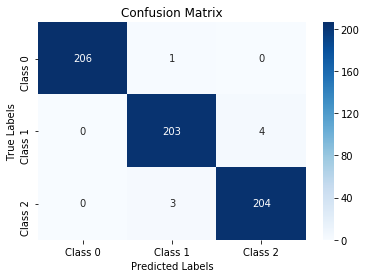

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels_CN1, predicted_labels)

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

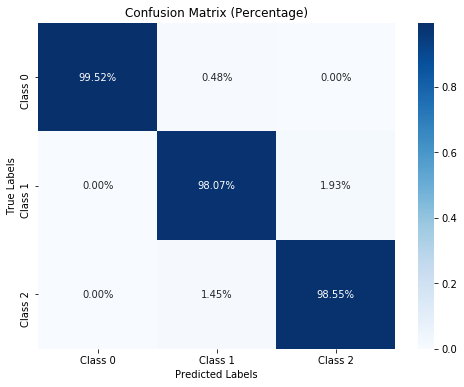

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels_CN1, predicted_labels)

# Convert to percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))

# heatmap with annotations and percentages
sns.heatmap(conf_matrix_percentage, annot=True, fmt=".2%", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])

plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Classification Report
class_names = ["Class 0", "Class 1", "Class 2"]
report = classification_report(true_labels_CN1, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
             precision    recall  f1-score   support

    Class 0       1.00      1.00      1.00       207
    Class 1       0.98      0.98      0.98       207
    Class 2       0.98      0.99      0.98       207

avg / total       0.99      0.99      0.99       621



In [ ]:
# Calculate the overall accuracy
overall_accuracy = accuracy_score(true_labels_CN1, predicted_labels)
print(f'Overall Accuracy: {overall_accuracy:.4f}')

Overall Accuracy: 0.9871
